In [1]:
import pandas as pd
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [2]:
def linear_acc(data):
    alpha = 0.9
    linearacc = pd.DataFrame()
    g = 0           
    for r in range(len(data)):      #1行ずつ見る   
        #Isolate the force of gravity with the low-pass filter.
        g = alpha*g + (1-alpha) * data.loc[r]
        #Remove the gravity contribution with the high-pass filter.
        linear = data.loc[r] - g
        linearacc =linearacc.append(linear,ignore_index=True)
    return linearacc

In [3]:
def rotations(grad_data):
    #for each time point, get alpha angle 
    #x axis = col 0 and col 3 
    x1 = grad_data[:,0]
    x2 = grad_data[:,3]
    #y axis = col1 and col4
    y1 = grad_data[:,1]
    y2 = grad_data[:,4]
    
    m = (y1-y2)/(x1-x2)
    alpha = np.arctan(m)
    theta = np.pi - alpha
    return theta

In [4]:
m_path = "/Users/takeshin/odrive/sozolab_gdrive/students/Shingo/BerkeleyMHAD/Mocap/OpticalData/moc_s03_a01_r02.txt"
acc_path = "/Users/takeshin/odrive/sozolab_gdrive/students/Shingo/BerkeleyMHAD/Accelerometer/Shimmer01/acc_h01_s03_a01_r02.txt"

mocap_sampling_rate = 480
acc_sampling_rate = 30
decimate_factor = mocap_sampling_rate/acc_sampling_rate


In [5]:
axis = ['X', 'Y', 'Z']
markers = 43
header_s = ['m_'+str(i)+'_'+ax for i in range(1, markers+1) for ax in axis]
#header.append('frame_number')
header_total = list(header_s + ['frame_number','time'])

df = pd.read_csv(m_path, sep=' ', header=None,names=header_total)
df.replace(to_replace=0, value=np.NaN, inplace = True)
df.interpolate(inplace=True)
df.replace(to_replace=np.NaN, value=0, inplace = True)

In [6]:
acc_df = pd.read_csv(acc_path, sep=' ', header=None)
acc_df = acc_df[[0,1,2]]
acc_df.interpolate(inplace=True)
acc_df = linear_acc(acc_df)
acc_df = sig.medfilt(acc_df.values, kernel_size = [3,1]) #median filter on columns

In [7]:
#use marker 16, 17 and 18 for acc 1
df = df[['m_16_X', 'm_16_Y','m_16_Z','m_17_X', 'm_17_Y','m_17_Z']]

#decimate down sampling
df = sig.decimate(df, q=int(decimate_factor), axis=0)

#obtain angles
angles = rotations(df)

#take gradient 
vel_df = np.gradient(df, axis=0)
grad_df = np.gradient(vel_df, axis=0) #second derivative 
grad_df = grad_df*0.001*900/9.80665 #unit conversion

#accelerometer only reads 2 grav
grad_df[grad_df>1.5]=1.5
grad_df[grad_df<-1.5]=-1.5

#unit conversion
grad_df = sig.medfilt(grad_df, kernel_size = [3,1]) #median filter on columns
#grad_df = pd.DataFrame(grad_df).rolling(window= 7, center=False).median()
#grad_df = grad_df.dropna()
#grad_df = grad_df.reset_index()

/Users/takeshin/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/takeshin/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [8]:
print(len(grad_df))
print(len(acc_df))
print(len(angles))

148
153
148


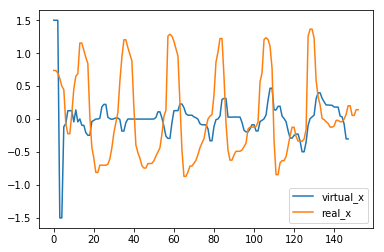

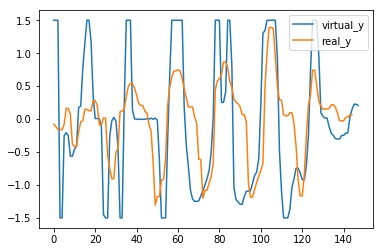

In [9]:
plt.plot(grad_df[:,0],label='virtual_x')
plt.plot(acc_df[:,0], label='real_x')
plt.legend()
plt.show()

plt.plot(grad_df[:,1],label='virtual_y')
plt.plot(acc_df[8:,1], label='real_y')
plt.legend()
plt.show()


#coef1x = np.corrcoef(acc_df[:175,0], grad_df[:,3], rowvar=False)[0,1]
#coef1y = np.corrcoef(acc_df[:175,1], grad_df[:,4], rowvar=False)[0,1]

coef1x = np.corrcoef(acc_df[:len(grad_df),0], grad_df[:,0], rowvar=False)[0,1]
coef1y = np.corrcoef(acc_df[:len(grad_df),1], grad_df[:len(grad_df),1], rowvar=False)[0,1]

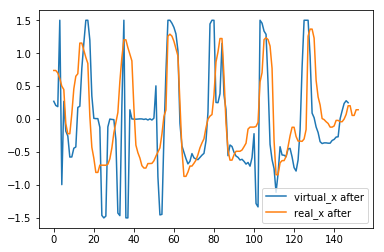

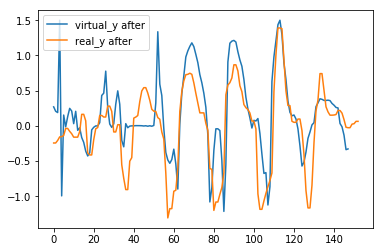

In [10]:
#df_x = grad_df[:,0]*np.cos(angles) + grad_df[:,1]*np.sin(angles)
#df_y = -grad_df[:,0]*np.sin(angles) + grad_df[:,1]*np.cos(angles)

df_x = grad_df[:,0]*np.cos(angles) + grad_df[:,1]*np.sin(angles)
df_y = grad_df[:,0]*np.sin(angles) + grad_df[:,1]*np.cos(angles)


grad_df[:,0] = df_x
grad_df[:,1] = df_y
grad_df[grad_df>1.5]=1.5
grad_df[grad_df<-1.5]=-1.5

plt.plot(grad_df[:,0],label='virtual_x after')
plt.plot(acc_df[:,0], label='real_x after')
plt.legend()
plt.show()

plt.plot(grad_df[:,1],label='virtual_y after')
plt.plot(acc_df[:,1], label='real_y after')
plt.legend()

#coef2x= np.corrcoef(acc_df[:175,0], grad_df[:,3], rowvar=False)[0,1]
#coef2y= np.corrcoef(acc_df[:175,1], grad_df[:,4], rowvar=False)[0,1]

coef2x= np.corrcoef(acc_df[:len(grad_df),0], grad_df[:len(grad_df),0], rowvar=False)[0,1]
coef2y= np.corrcoef(acc_df[:len(grad_df),1], grad_df[:len(grad_df),1], rowvar=False)[0,1]


In [11]:
print('coef before x:' , coef1x , ', y: ' , coef1y)
print('coef after x:' , coef2x , ', y: ' , coef2y)

coef before x: 0.04904699969085011 , y:  -0.7387822688091005
coef after x: 0.519241254308679 , y:  0.7072455101121875
